### Importing Libraries

In [1]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization,Rescaling, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

In [2]:
plt.rcParams['figure.figsize'] = (8,10)

In [3]:
# !pip install tesseract-ocr

In [4]:
# !pip install pytesseract


In [5]:
# !pip install tesseract

In [6]:
import pytesseract
import pickle
import cvzone
import numpy as np
from sre_constants import SUCCESS
import pyqrcode
from pyzbar.pyzbar import decode
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\angie\Tesseract-OCR\tesseract.exe'

In [7]:
#!apt install libzbar0

In [8]:
# pip install cvzone

In [9]:
# pip install pyqrcode

In [10]:
# pip install pypng

In [11]:
# !pip install pyzbar

In [12]:
# pip install -q -U keras-tuner

In [13]:
import keras_tuner as kt

In [14]:
# !pip install ray

In [15]:
# pip install scipy

### Loading Images

In [16]:
# specifying the directory path with the image election data
path = "/content/drive/MyDrive/Group 1 IEBC Project/Official data"

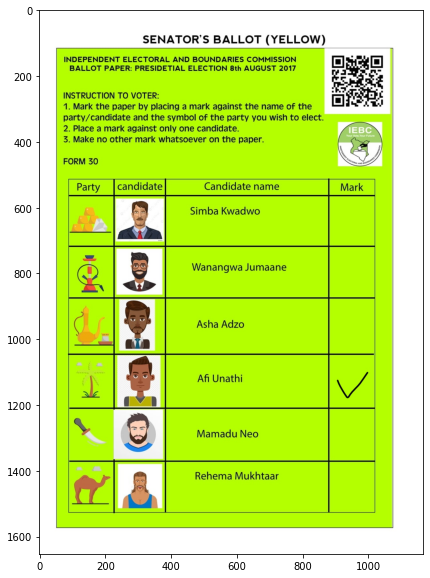

In [17]:
img_path = r"C:\Users\angie\Documents\Moringa School\Final Project - Computer Vision\Official data\senate\valid\nrb\im106.jpg"
image = Image.open(img_path)
plt.imshow(image)

In [18]:
# function for displaying images inline...from stack overflow
def display(img_array, scale_down):
  dpi=scale_down
  height, width, depth =img_array.shape

  # what size does the figure need to be in inches to fit the image?
  figsize = width/ float(dpi), height/ float(dpi)

  # create a figure of the right size with one axes that takes up the full figure
  fig =plt.figure(figsize = figsize)
  ax = fig.add_axes([0,0,1,1])

  # Hide spines, ticks, etc
  ax.axis('off')

  # Display image
  ax.imshow(img_array, cmap='gray')
  plt.show()


# displays only one image

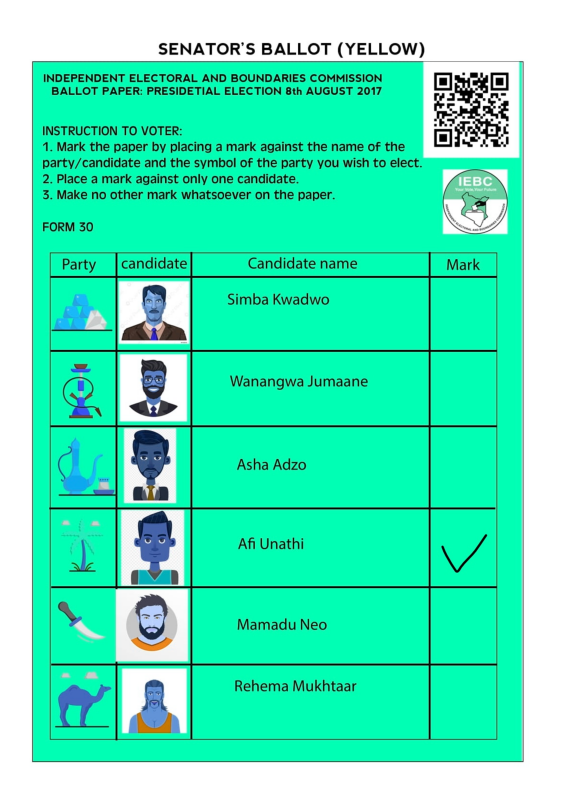

In [19]:
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
display(img, 150)

### Image preprocessing

In [20]:
# function for greyscaling an image
def grayscale(img_array):
  return cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)

In [21]:
# function for processing the image that will be fed into the mark recognition function
def process_mark_reg(img_array):

  # grayscaling the image
  imgGray = cv2.cvtColor(img_array,cv2.COLOR_BGRA2GRAY)
  # appying blur
  imgBlur = cv2.GaussianBlur(imgGray,(3,3),1)
  imgThreshhold = cv2.adaptiveThreshold(imgBlur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
  cv2.THRESH_BINARY_INV,25,16)
  imgmedialblur = cv2.medianBlur(imgThreshhold,3)
  # setting the kernel for dilation
  kernel = np.ones((3,3),np.uint8)
  # dilating the image after blurring
  imgdialate = cv2.dilate(imgmedialblur,kernel, iterations=1)
  return imgdialate


In [22]:
# dilation to make text thicker
def thick_font(image):
  image = cv2.bitwise_not(image)
  kernel = np.ones((2,2), np.uint8) # increasing the kernel size makes the font thicker
  image = cv2.dilate(image, kernel, iterations=1) #increasing the number of iterations makes the font thicker as well 
  image = cv2.bitwise_not(image)
  return(image)

In [23]:
# defining the custom function for preprocessing my model training data
def my_prep_func(image):
  # blurring image
  img_blur = cv2.GaussianBlur(image, (7,7),0 )
  img_blur = img_blur.astype(np.uint8)
  # setting threshold and kernel
  thresh = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10,12))
  # dilating the image
  dilate = cv2.dilate(thresh, kernel, iterations =1)
  # dilate = dilate.astype(np.float32)
  # expanding the array dimensions from 2 to 3
  final_img = np.expand_dims(dilate, axis=2)
  return final_img

In [24]:
# function for preprocessing before contouring
def my_prep_cont(image):
  # blurring image
  img_blur = cv2.GaussianBlur(image, (7,7),0 )
  img_blur = img_blur.astype(np.uint8)
  # setting threshold and kernel
  thresh = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10,12))
  # dilating the image
  dilate = cv2.dilate(thresh, kernel, iterations =1)
  return dilate

### QR code reader

In [25]:
# making a copy of the ballot paper
cont_img = img.copy()
# preprocessing my image for contouring
gray_img = grayscale(img)
to_contour = my_prep_cont(gray_img)

# drawing contours onto my image to pinpoint the bounding box containing the qr code
cnts = cv2.findContours(to_contour, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0 if len(cnts) == 2 else cnts[1]]
cnts = sorted(cnts, key =lambda x: cv2.boundingRect(x)[0])
for c in cnts:
  x, y, w, h = cv2.boundingRect(c)
  if h > 150 and w >  150 and h < 300 and w < 300:
    roi = img[y:y+h, x:x+w]
    cv2.rectangle(cont_img, (x, y), (x+w, y+h), (12,36,255), 2)

cv2.imwrite(r"C:\Users\angie\Documents\Moringa School\Final Project - Computer Vision\IEBCV\bounded.jpg", cont_img)

True

In [26]:
# reading the qr code
d = decode(roi)
data = d[0].data.decode('ascii')
print(data)

Valid,Nairobi,DagorettiNorth,NAIROBI_PRIMARYSCHOOL


In [27]:
data_split = data.split(",")
print(data_split)

['Valid', 'Nairobi', 'DagorettiNorth', 'NAIROBI_PRIMARYSCHOOL']


In [28]:
# Create your dictionary class
# class my_dictionary(dict):
  
#     # __init__ function
#     def __init__(self):
#         self = dict()
          
#     # Function to add key:value
#     def add(self, key, value):
#       if key not in self:
#         self[key] = [value]
#       elif key in self:
#         self[f'{key}'] = self[f'{key}'].extend(value)

  
# # Main Function
# dict_obj = my_dictionary()
  
# dict_obj.add("Validity", data_split[0])
# dict_obj.add("County", data_split[1])
# dict_obj.add("Constituency", data_split[2])
# dict_obj.add("Polling Station", data_split[3])
# dict_obj.add("County", "Mombasa")
  
# print(dict_obj)

In [29]:
def add_vals(dic,key, values):
  if key not in dic:
    dic[key] = list()
  dic[key].extend(values)
  

In [30]:
datadict = { }
add_vals(datadict, "Validity", [data_split[0]])
add_vals(datadict, "County", [data_split[2]])
add_vals(datadict, "County", ["Mombasa"])
add_vals(datadict, "County", ["Nairobi"])

In [31]:
datadict

{'Validity': ['Valid'], 'County': ['DagorettiNorth', 'Mombasa', 'Nairobi']}

### Mark reader and text extraction

In [32]:
# resizing the image
imgwidth = 660
imgheight = 750
imag = cv2.resize(img,(imgwidth,imgheight))

# setting dimensions for bounding boxes
width, height = 80, 65



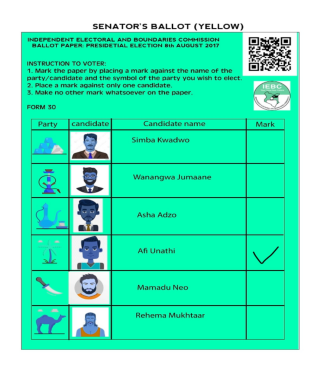

In [33]:
display(imag,150)

In [34]:
# creating a copy of the image
clone = imag.copy()


In [35]:
# defining the coordinates for the positions of the bounding boxes for candidate names and the marks

# storing the data for their coordinates in a list
# the arrangement is typically in tuple format in the following order(left, top, right, bottom)
candi_coordinates = [(244,250,474,320),(244,320,474,380),(244,390,474,470),(244,480,474,550),(244,550,474,620),(244,620,474,670)]
pos_marks = [(497, 257), (497, 328), (499, 401), (498, 478), (499, 553), (499, 625)]

In [36]:
# while True:
#     img = cv2.imread(r'C:\Users\angie\Documents\Moringa School\Final Project - Computer Vision\Official data\senate\valid\nrb\im6.jpg')
#     imgwidth = 660
#     imgheight = 750
#     img = cv2.resize(im,(imgwidth,imgheight))

#     for pos in positionlist:
#         #cv2.rectangle(img,pos)
#         cv2.rectangle(img,pos,(pos[0]+width,pos[1]+height),(255,0,255),2)


#     cv2.imshow('image',img)
#     cv2.setMouseCallback('image',mouseclick)
#     cv2.waitKey(1)

In [37]:
# thickening font
# thicker = thick_font(grayscale(imag))
# path_t = r"C:\Users\angie\Documents\Moringa School\Final Project - Computer Vision\IEBCV\processed_mark_img.jpg"
# cv2.imwrite(path_t, thicker)
# imgpro = Image.open(path_t)
# plt.imshow(imgpro)


In [38]:
processed_imag = process_mark_reg(imag)

In [39]:
# defining the function for checking the marks on the ballot papers
def checkformark(imgpro):
  thicker = thick_font(grayscale(imag))
  thicker = Image.fromarray(np.uint8(thicker))
  i = 0
  for pos in pos_marks:
    #specifying the coordinates for our mark bounding boxes
    x,y = pos

    # cropping the image and computing the number of pixels in each
    imgcrop = imgpro[y:y+height, x:x+width]
    # cropping the candidate name
    cropped  = thicker.crop(candi_coordinates[i])

    # counting number of pixels
    count = cv2.countNonZero(imgcrop)
    cvzone.putTextRect(imag, str(count),(x,y+height-10), scale=1,thickness=1,offset=0)
    
    # to determine the where the ballot is marked the count for pixels is investigated.
    # we set a condition that where the number of pixels exceed 700, the ballot is considered marked
    if count > 700:
      color =(255,0,0)
      thickness = 5
      cv2.rectangle(imag,pos,(pos[0]+width-350,pos[1]+height),(255,0,255),thickness)
      read_name = pytesseract.image_to_string(cropped)

    else:
      color = (0,0,255)
      thickness = 2
    cv2.rectangle(imag,pos,(pos[0]+width,pos[1]+height),color,thickness)
    i +=1

  
  return imag, read_name




In [40]:
markchecked, name= checkformark(processed_imag)

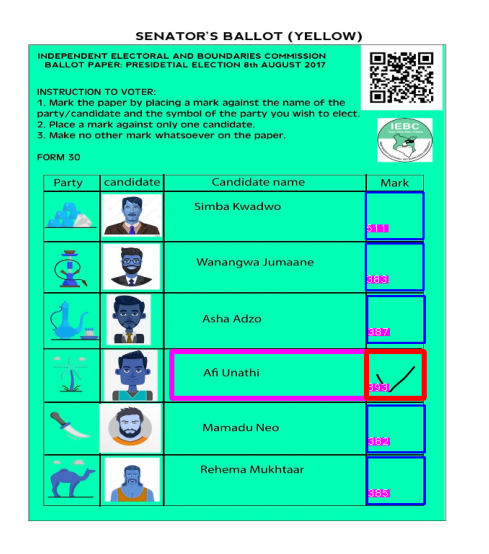

In [41]:
display(markchecked,100)

In [42]:
print(name)

Afi Unathi



In [59]:
add_vals(datadict, "Candidate", [name])

In [65]:
add_vals(datadict, "Valid", ['Valid'])

In [66]:
datadict

{'Validity': ['Valid', 'Valid', 'Valid'],
 'County': ['DagorettiNorth', 'Mombasa', 'Nairobi'],
 'Candidate': ['Afi Unathi\n', 'Afi Unathi\n', 'Afi Unathi\n'],
 'Valid': ['Valid', 'Valid', 'Valid']}

In [53]:
import pandas as pd

In [67]:
df = pd.DataFrame.from_dict(datadict)
df.head()

,Validity,County,Candidate,Valid
0,Valid,DagorettiNorth,Afi Unathi\n,Valid
1,Valid,Mombasa,Afi Unathi\n,Valid
2,Valid,Nairobi,Afi Unathi\n,Valid


In [68]:
df.to_csv(r'C:\Users\angie\Documents\Moringa School\Final Project - Computer Vision\IEBCV\trial.csv', encoding='utf-8')

In [ ]:
# check the checkboxes for marks
# def checkformark(imgpro):
#     for pos in positionlist:
#         #cv2.rectangle(img,pos)
#         x,y = pos
        

#         #croping and extracting the image
#         imgcrop = imgpro[y:y+height,x:x+width]
#         cv2.imshow(str(x*y),imgcrop)   
#         count = cv2.countNonZero(imgcrop)
#         cvzone.putTextRect(img,str(count),(x,y+height-10),scale=1,thickness=1,offset=0)


        
#         # well count the pixels, if they are greater than 1350 then well consider
#         #the region marked.
#         if count>700:
#             color = (0,255,0)
#             thickness = 5
#             roi = img[y:y, x:x+256]
#             # ocr_result = pytesseract.image_to_string(roi)
#             # print(ocr_result)

#         else:
#             color = (0,0,255)
#             thickness = 2
#         cv2.rectangle(img,pos,(pos[0]+width,pos[1]+height),color,thickness)



# while True:
#     img = cv2.imread(r'C:\Users\angie\Documents\Moringa School\Final Project - Computer Vision\IEBCV\mark recognition\prnairobidagoballot_test\prnairobidagoballot (6) (3rd copy)-1.jpg')
#     #img = cv2.imread('new_ballot-papers/prnairobidagoballot.jpg')
#     imgwidth = 660
#     imgheight = 750
#     img = cv2.resize(im,(imgwidth,imgheight))

#     imgGray = cv2.cvtColor(img,cv2.COLOR_BGRA2GRAY)
#     imgBlur = cv2.GaussianBlur(imgGray,(3,3),1)
#     imgThreshhold = cv2.adaptiveThreshold(imgBlur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#     cv2.THRESH_BINARY_INV,25,16)
#     imgmedialblur = cv2.medianBlur(imgThreshhold,3)
#     kernel = np.ones((3,3),np.uint8)
#     imgdialate = cv2.dilate(imgmedialblur,kernel, iterations=1)

#     checkformark(imgdialate)    

#     #for pos in positionlist:
        

    
#     cv2.imshow('image',img)
#     cv2.imshow('threshhold',imgdialate)

#     cv2.waitKey(1)

### Image classification

#### Custom preprocessing function

In [ ]:
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters


In [ ]:
training = ImageDataGenerator(preprocessing_function=my_prep_func)
validation = ImageDataGenerator(preprocessing_function=my_prep_func)

In [ ]:
train = training.flow_from_directory(r"C:\Users\angie\Documents\Moringa School\Final Project - Computer Vision\Vote Validation Model data\Train",
                                     target_size=(800,800), 
                                     batch_size=28, class_mode="binary", color_mode='grayscale')
valiset = training.flow_from_directory(r'C:\Users\angie\Documents\Moringa School\Final Project - Computer Vision\Vote Validation Model data\Validation set', 
                                     target_size=(800,800), 
                                     batch_size=28, class_mode="binary", color_mode='grayscale')

In [ ]:
train.shuffle
valiset.shuffle

In [ ]:
def plot_images(img_arr):
  fig, axes =plt.subplots(1,10, figsize=(20,20))
  axes = axes.flatten()
  for img, ax in zip(img_arr, axes):
    ax.imshow(img[:,:,0], cmap='gray')
    ax.axis('off')
  plt.tight_layout()
  plt.show()

imgs, labels = next(train)

plot_images(imgs)
print(labels)

In [ ]:
modc = Sequential()

modc.add(Conv2D(32, (5, 5), strides = (1, 1), name = 'conv0', input_shape = (800, 800, 1)))

modc.add(BatchNormalization(axis = 3, name = 'bn0'))
modc.add(Activation('relu'))

modc.add(MaxPooling2D((2, 2), name='max_pool'))
modc.add(Conv2D(64, (3, 3), strides = (1,1), name="conv1"))
modc.add(Activation('relu'))
modc.add(AveragePooling2D((3, 3), name='avg_pool'))

modc.add(GlobalAveragePooling2D())
modc.add(Dense(300, activation="relu", name='rl'))
modc.add(Dropout(0.5))
modc.add(Dense(1,activation='sigmoid', name='sm'))

In [ ]:
modc.compile(loss= "binary_crossentropy", 
              optimizer= "adadelta",
              metrics =["accuracy"])

In [ ]:
modc_fit = modc.fit(train, steps_per_epoch =5, epochs=18, validation_data= valiset)

In [ ]:
def build_model(hp):
  model = Sequential()
  model.add(Conv2D(hp.Int("input_units", 32,128,32), (5,5), strides=(1,1),input_shape=(800,800,1)))
  model.add(BatchNormalization(axis=3))
  model.add(Activation('relu'))

  for i in range(hp.Int("n_layers", 1,3)):
    model.add(Conv2D(hp.Int(f"conv_{i}_units", 32, 128, 32), (3, 3)))
    model.add(Activation('relu'))
  
  model.add(Dense(300, activation="relu", name='rl'))
  model.add(Dropout(0.5))
  model.add(Dense(2,activation='softmax', name='sm'))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(loss= "sparse_categorical_crossentropy", 
              optimizer= keras.optimizers.Adam(learning_rate=hp_learning_rate),
              metrics =["accuracy"])
  return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective = "val_accuracy",
    max_trials =1,
    directory =r"C:\Users\angie\Documents\Moringa School\Final Project - Computer Vision\IEBCV",
    executions_per_trial =1,
    project_name ="ballot_paper_validation"
)

In [ ]:
tuner.search(train, epochs = 1, batch_size=28,validation_data = valiset)

In [ ]:
best_hps=tuner.get_best_hyperparameters()[0]
print(best_hps)

In [ ]:
# obtaining the best model
best_mod = tuner.get_best_models()[0]
# displaying the summary of the model
best_mod.summary()

In [ ]:
# modc = Sequential()

# modc.add(Conv2D(32, (5, 5), strides = (1, 1), name = 'conv0', input_shape = (900, 900, 1)))

# modc.add(BatchNormalization(axis = 3, name = 'bn0'))
# modc.add(Activation('relu'))

# modc.add(MaxPooling2D((2, 2), name='max_pool'))
# modc.add(Conv2D(64, (3, 3), strides = (1,1), name="conv1"))
# modc.add(Activation('relu'))
# modc.add(AveragePooling2D((3, 3), name='avg_pool'))

# modc.add(GlobalAveragePooling2D())
# modc.add(Dense(300, activation="relu", name='rl'))
# modc.add(Dropout(0.5))
# modc.add(Dense(1,activation='sigmoid', name='sm'))

In [ ]:
# modc = Sequential([tf.keras.layers.Conv2D(16, (3,3), activation ="relu", input_shape =(1000,800,1)),
#                     tf.keras.layers.MaxPool2D(2,2),
#                     tf.keras.layers.Conv2D(32, (3,3), activation ="relu", input_shape =(1000,800,1)),
#                     tf.keras.layers.MaxPool2D(2,2),
#                     tf.keras.layers.Conv2D(64, (3,3), activation ="relu", input_shape =(1000,800,1)),
#                     tf.keras.layers.MaxPool2D(2,2),
#                     tf.keras.layers.Flatten(),
#                     tf.keras.layers.Dense(512, activation="relu"),
#                     tf.keras.layers.Dense(1, activation="sigmoid")
#                     ])

In [ ]:
for i in os.listdir(dir_path):
  img = image.load_img(dir_path + '//'+ i)

  X = image_to_array(img)
  X = np.expand_dims(X, axis=0)



  #......
  val = best_mod.predict()